In [1]:
import networkx as nx
import numpy as np
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
%matplotlib inline


In [67]:
class Problem(object):
    def __init__(self,n_cities):
        self.tsp=self.setup_tsp(n_cities)
        #self.a=agent()

    def setup_tsp(self,n_cities):

        #locations
        x=np.random.permutation(range(0,n_cities))
        y=np.random.permutation(range(0,n_cities))

        #nodes
        g=nx.Graph()
        for i in range(0,n_cities):
            g.add_node(i,loc=(x[i],y[i]))

        #edges
        cg=nx.complete_graph(n_cities)
        for u,v in cg.edges():
            #get distance
            #d=((g.node[u]['loc'][0]-g.node[v]['loc'][0])**2+(g.node[u]['loc'][1]-g.node[v]['loc'][1])**2)**.5
            #print u,v,d
            g.add_edge(u,v) #g.add_edge(u,v,dist=d)
        #plt.scatter(x,y)

        return g
    
    

In [84]:
class agent(object):
    def __init__(self,perspective):
        self.k=nx.DiGraph()
        self.score=perspective
        self.landscape={}
        
    def solve(self,tsp):
        #random route
        r=np.random.permutation(tsp.nodes())
        
        #score route
        s,k_r=self.score(r,tsp)
        
        #Save route and score
        self.landscape[r]=s
        
        
        
        
        
        
    

In [144]:
class KD_Graph(object):
    def __init__(self,oracle=None):
        self.k=nx.DiGraph()
        self.d=nx.DiGraph()
        self.l=[] #list of landscape nodes
        self.tt={'t':0,'tau':0}
        self.tau_marks={}
        #self.tau=0
        self.hist_k={self.tt['t']:self.k.copy()} #{time:k}
        self.change_k={} #{time of change: edges added}
        self.hist_d={self.tt['tau']:self.d.copy()} #{tau:d}
        self.change_d={} #{time of change: edges added}
        self.hist_l={self.tt['t']:list(self.l)} #{time:landscape nodes}
        #self.oracle=self.test_kd
        
    def add_k(self,node,s,c=[], n_id=None, l=None, data=None): #s are constraining pred, c are coordinating preds
        self.k.add_node(node, n_id=n_id, l=l, data=data, t=self.tt['t'])
        e_list=[]
        for n in s:
            self.k.add_edge(n,node,e_type='s',t=self.tt['t'])
            e_list.append((n,node))
        for n in c:
            self.k.add_edge(n,node,e_type='c',t=self.tt['t'])
            e_list.append((n,node))
        
        if l:
            self.l.append(node)
            
        self.hist_l[self.tt['t']]=list(self.l)
        self.change_k[self.tt['t']]=list(e_list)
        self.hist_k[self.tt['t']]=self.k.copy()
        self.tau_marks[self.tt['t']]=self.tt['tau']
        self.tt['t']+=1
        
    def add_d(self, node, s): #Makes decision - all edges (s[:],n) must be in k of type 's'
        #is decision valid?
        
        accept=1
        for n in s:
            #in k?
            if (n,node) not in self.k.edges():
                # type 's'
                accept=0
                print '({},{}) not in k'.format(n,node)
            elif self.k[n][node]['e_type']!='s':
                accept=0
                print '({},{}) is not constraining'.format(n,node)       
                
        if accept==1: #valid
            e_list=[]
            self.d.add_node(node,tau=self.tt['tau'],
                            n_id=self.k.node[node]['n_id'],
                            l=self.k.node[node]['l'],
                            data=self.k.node[node]['data'])
            for n in s:
                self.d.add_edge(n,node,tau=self.tt['tau'])
            
            self.hist_l[self.tt['t']]=list(self.l)
            self.hist_k[self.tt['t']]=self.k.copy()
            self.hist_d[self.tt['tau']]=self.d.copy()
            self.tau_marks[self.tt['t']]=self.tt['tau']+1
            self.tt['t']+=1
            self.tt['tau']+=1
        else:
            print 'decision not valid'
            
    def remove_d(self,node,s):
        # is decision in  D?
        accept=1
        for n in s:
            if (n,node) not in self.d.edges():
                accept=0
                print '({},{}) not in d'.format(n,node)
        if accept==1: #valid
            for n in s:
                self.d.remove_edge(n,node)
                
            self.hist_l[self.tt['t']]=list(self.l)
            self.hist_k[self.tt['t']]=self.k.copy()    
            self.hist_d[self.tt['tau']]=self.d.copy()
            self.tau_marks[self.tt['t']]=self.tt['tau']
            self.tt['t']+=1
            self.tt['tau']+=1
        else:
            print 'removal not valid'
            
#        for n in self.d: #remove dead
#            if self.d.out_degree(n)==0 and self.d.in_degree(n)==0:
#                self.d.remove_node(n)    
    
    #Add landscape parsing
    def get_landscape(self,t,tau):
        k=self.hist_k[t]
        d=self.hist_d[tau]
        l=self.hist_l[t]
        
        valid_l=[]
        scores=[]
        for n in l:
            nodes=self.k.predecessors(n)
            sub_g=self.k.subgraph(nodes).copy()
            DiGM = iso.DiGraphMatcher(sub_g,d,node_match=nm)
            if DiGM.subgraph_is_isomorphic():
                valid_l.append(n)
                scores.append(self.k.node[n]['l'])
                
            #if self.test_kd(sub_g,d)==1:
                #valid_l.append(n)
        plt.hist(scores)
                
        
        
                
    def test_kd(self,s_g,d):
        #get bunches
        nm=iso.categorical_node_match('data',1)
        k_bunch={}
        for u,v,d in s_g.edges_iter(data=True):
            t=d['t']
            k_bunch.setdefault(t,[]).append((self.k.node[u]['data'],self.k.node[v]['data'])) #save data edges
            
        d_bunch={}
        for u,v,d in d.edges_iter(data=True):
            tau=d['tau']
            d_bunch.setdefault(tau,[]).append((self.d.node[u]['data'],self.d.node[v]['data'])) #save data edges
        

        for tau,d in d_bunch.iteritems():
            for t,k in k_bunch.iteritems():
                DiGM = iso.DiGraphMatcher(k,d,node_match=nm)
                #if DiGM.subgraph_is_isomorphic():
                    
                    
                    
                
                                            
        
            
        
            
            

In [85]:
def perspective(route,tsp):
    s=0.0
    k={}
    for i in xrange(len(route)-1):
        u=route[i]
        v=route[i+1]
        d=((g.node[u]['loc'][0]-g.node[v]['loc'][0])**2+(g.node[u]['loc'][1]-g.node[v]['loc'][1])**2)**.5
        k[(u,v)]=d
        s+=d
        
    return s,k
    

In [4]:
g=nx.complete_graph(4)
print g.nodes()
print g.edges()
print (0,1) in g.edges()

[0, 1, 2, 3]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
True


In [11]:
np.random.permutation(range(0,4))

array([2, 3, 1, 0])

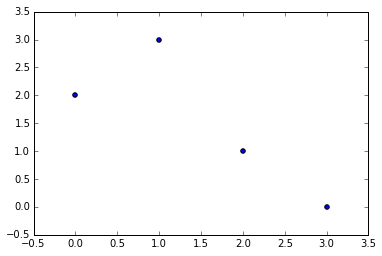

In [80]:
g=setup_tsp(4)


In [81]:
print g.nodes(data=True)
print g.edges(data=True)

[(0, {'loc': (3, 0)}), (1, {'loc': (0, 2)}), (2, {'loc': (2, 1)}), (3, {'loc': (1, 3)})]
[(0, 1, {'dist': 3.6055512754639891}), (0, 2, {'dist': 1.4142135623730951}), (0, 3, {'dist': 3.6055512754639891}), (1, 2, {'dist': 2.2360679774997898}), (1, 3, {'dist': 1.4142135623730951}), (2, 3, {'dist': 2.2360679774997898})]


In [38]:
g.node[0]

{'loc': (0, 3)}

In [54]:
plt.scatter(x,y)

NameError: name 'x' is not defined

In [70]:
p=Problem(4)

In [72]:
p.tsp.nodes()

[0, 1, 2, 3]

In [75]:
l=[0,1,2,3]
for i in xrange(len(l)-1):
    print l[i],l[i+1]

0 1
1 2
2 3


In [86]:
perspective([0,2,1,3],g)

(5.0644951022459797,
 {(0, 2): 1.4142135623730951,
  (1, 3): 1.4142135623730951,
  (2, 1): 2.2360679774997898})

In [87]:
g[0][1]

{'dist': 3.6055512754639891}

[1] {0: []}
{'tau': 0, 't': 1}
{'tau': 0, 't': 2} [1, 2] [] {0: [], 1: [2]}
{'tau': 1, 't': 3} [1, 2] [1, 2]
[(1, 2)] [1, 2] [(1, 2)]
{'tau': 2, 't': 4} [(1, 2)] [1, 2] []
{'n_id': None, 'data': 1, 'l': 10, 't': 1}
{0: [], 1: [2]}
{0: 0, 1: 0, 2: 0, 3: 1} {0: [], 1: [(1, 2)]} {0: <networkx.classes.digraph.DiGraph object at 0x0000000009C5BA90>, 1: <networkx.classes.digraph.DiGraph object at 0x0000000009C5B6D8>, 2: <networkx.classes.digraph.DiGraph object at 0x0000000007E10B70>, 3: <networkx.classes.digraph.DiGraph object at 0x00000000095445F8>}


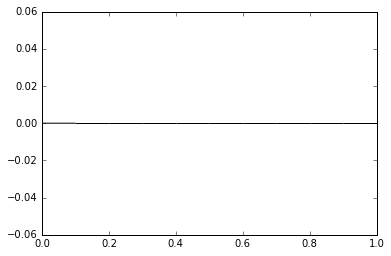

In [62]:
k=KD_Graph()
k.add_k(1,[],data=0) #0
print k.k.nodes(), k.hist_l
print k.tt
k.add_k(2,[1],l=10,data=1) #1
print k.tt,k.k.nodes(), k.d.nodes(), k.hist_l
k.add_d(2,[1]) #2
print k.tt, k.k.nodes(), k.d.nodes()
print k.hist_k[1].edges(), k.hist_d[0].nodes(), k.d.edges()
k.remove_d(2,[1]) #3
print k.tt, k.hist_k[1].edges(), k.hist_d[1].nodes(),k.d.edges()
print k.k.node[2]
print k.hist_l
print k.tau_marks, k.change_k, k.hist_k
k.get_landscape(t=1,tau=1)

In [18]:
t={1:10}
t[2]=12
print t

{1: 10, 2: 12}


In [25]:
tt={'t':0,'tau':0}
#tt[tau]
tt['tau']+=1
print tt

{'tau': 1, 't': 0}


In [60]:
print k.d.out_degree(2)
print k.d.in_degree(2)

0
0


In [72]:
g=nx.Graph()
g.add_node(1,data='hi')
print g.node[1]['data']

hi


In [14]:
t={}
t.setdefault(1,[1])
t.setdefault(1,[]).append(3)


print t

{1: [1, 3]}


In [4]:
import networkx.algorithms.isomorphism as iso

In [5]:
G1 = nx.path_graph(4, create_using=nx.DiGraph())
G1.node[1]['n']='hi'
print G1.node[1]
G2 = nx.path_graph(2, create_using=nx.DiGraph())
G2.node[1]['n']='bi'
nm=iso.categorical_node_match('n',1)
DiGM = iso.DiGraphMatcher(G1,G2,node_match=nm)
DiGM.subgraph_is_isomorphic()

{'n': 'hi'}


False

In [122]:
k=nx.DiGraph()
k.add_node(1,data=(1,2))
k.add_node(2,data=(2,3))
k.add_node(3,data=(3,1))
k.add_edge(1,2)
k.add_edge(2,3)
k.add_edge(1,3)


d=nx.DiGraph()
#d.add_node('a',data=(1,2))
d.add_node('b',data=(2,3))
#d.add_edge('a','b')

nm=iso.categorical_node_match('data',1)
DiGM = iso.DiGraphMatcher(k,d,node_match=nm)
DiGM.subgraph_is_isomorphic()

True

In [147]:
k=KD_Graph()
#k for route 1
k.add_k(1,s=[],data=(1,2))
k.add_k(2,s=[1],data=(2,3))
k.add_k(3,s=[1,2],data=(3,4))
k.add_k('e_1',s=[1,2,3],l=5)

#k for route 2
k.add_k(4,s=[1],data=(2,4))
k.add_k(5,s=[1,4],data=(4,3))
k.add_k('e_2',s=[1,4,5],l=10)

#d
k.add_d(1,s=[])
#k.add_d(4,s=[])


In [148]:
print k.hist_l
print k.hist_k
print k.hist_d
print k.tau_marks
#print k.diff_d

{0: [], 1: [], 2: [], 3: ['e_1'], 4: ['e_1'], 5: ['e_1'], 6: ['e_1', 'e_2'], 7: ['e_1', 'e_2']}
{0: <networkx.classes.digraph.DiGraph object at 0x0000000009FCBAC8>, 1: <networkx.classes.digraph.DiGraph object at 0x0000000009FCB588>, 2: <networkx.classes.digraph.DiGraph object at 0x0000000009B7C908>, 3: <networkx.classes.digraph.DiGraph object at 0x000000000A406DA0>, 4: <networkx.classes.digraph.DiGraph object at 0x0000000009F60F28>, 5: <networkx.classes.digraph.DiGraph object at 0x0000000009F60358>, 6: <networkx.classes.digraph.DiGraph object at 0x0000000009F60550>, 7: <networkx.classes.digraph.DiGraph object at 0x00000000096B2240>}
{0: <networkx.classes.digraph.DiGraph object at 0x000000000818DEF0>}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1}


In [150]:
k.get_landscape(t=8,tau=0)

KeyError: 8

In [77]:
l=None
if l:
    print 'hi'
else:
    print 'bi'

bi
